# Simulation of Haber-Bosch process in a fixed bed reactor.

Haber-Bosch process involves the conversion of $N_{2}$ and $H_{2}$ to $NH_{3}$ through a magnetite assisted ($Fe_{3}O_{4}@K$) catalyst, balances of mass and energy are vital to understand the behavior of the process, and study the influence of different parameters on the process.

### Mass balance

$$
\frac{dX}{dL} = \frac{R_{NH_{3}}\cdot \eta \cdot A_{reactor}}{2F_{N_{2}}}
$$

### Energy balance

$$
\frac{dT}{dL} = \frac{-\Delta_{r}H\cdot \eta \cdot R_{NH_{3}}}{F_{total}\cdot C_{p, mix}}
$$

### Total molar flowrate
$$
F_{total} = u\cdot C \cdot A
$$

where $u$ is the velocity flow measured as $m\cdot h^{-1}$, $C$ is the concentration of reactant measured in $kmol \cdot m^{-3}$, and $A$ is the area of the reactor measured in $m^2$, molar flow units $F$ are given in $kmol\cdot h^{-1}$.

### Ammonia rate production

$$
R_{NH_{3}} = 2k \left( K^2_{eq}\cdot a_{N_{2}}\left[ \frac{a^3_{H_{2}}}{a^2_{NH_{3}}}\right]^{\alpha} - \left[ \frac{a^2_{NH_{3}}}{a^3_{H_{2}}}\right]^{1-\alpha} \right)
$$

#### Gas activities

$$
a_{x} = y_{x}\cdot \phi_{x}\cdot P
$$

#### Kinetic constant

From Arrhenius

$$
k = k_{0}\cdot e^{-E_{a}/RT}
$$

### Equilibria constant

$$
log \ K_{eq} = -2.792312\cdot logT - 5.527463\cdot 10^{-5}T + 1.837742\cdot 10^{-5}T^2 + \frac{2002.4}{T} + 2.799
$$

### Fugacities

$$
(1) \ \phi_{N_2} = 0.94231827 + 0.2129547 \times 10^{-3} T + 28678509 \times 10^{-3} P - 0.280826 \times 10^{-6} T^2 + 0.4886308 \times 10^{-6} P^2
$$

$$
(2) \ \phi_{H_2} = \exp \left\{ \exp \left( -3.7301 T^{0.125} + 0.543 \right) \times P - \exp \left( -0.1374 T^{0.5} - 16.99 \right) \times P^2 + 314 \times \exp \left( -0.02291 T - 5.943 \right) \times \exp \left( -\frac{P}{300} \right) \right\}
$$

$$
(3) \ \phi_{NH_{3}} = 0.1327886 + 0.3038548 \times 10^{-2} T - 0.4397572 \times 10^{-3} P - 0.1233954 \times 10^{-5} T^2 + 0.2851314 \times 10^{-6} P^2
$$

### Molar fraction

$$
y_{x} = \frac{n_{x}}{\sum_{1}^{i}{n_{i}}}
$$

In [24]:
# Import libraries
import numpy as np # type: ignore
from sympy import solve, nsolve, symbols, expand, latex # type: ignore
from sympy.abc import x # type: ignore
import matplotlib.pyplot as plt # type: ignore
from utils import haber_modules as hm

Considering a reaction held at Haber-Bosch conditions of T = 723.15 K, P = 33.4 MPa, and $C_{N_{2}} = 20.0$, $C_{H_{2}} = 60.0$ in units of $kmol\cdot m^{-3}$. Operational flow conditions include an inert gas stream of Ar at a speed flow of 100 $m\cdot h^{-1}$.

In [2]:
f_n = hm.flow_rate(u=100, c=20, area=1) # Area has to be iterated to check performance
print(f"Molar flow rate of nitrogen gas: {f_n} kmol/h")

Molar flow rate of nitrogen gas: 2000 kmol/h


In [3]:
reagents = {'H_2': 60, 'N_2': 20, 'NH_3': 1e-10}

## Equilibria expression for Haber-Bosch process

$$
\begin{align*}
3H_{2} \ + N_{2} \ \rightleftharpoons \ 2NH_{3} \\
\ 600 \ \ \ \ \ \  200 \ \ \ \ \ \ \ \ 0 \ \ \ \ \ \ \ \ \ \\
\ 600-3x \ \ \ \   200-x \ \ \  \  +2x 
\end{align*}
$$

$$
K_{eq} = \frac { \left[ a^2_{NH_{3}} \right] } { \left[ a^3_{H_{2}} \right] \left[ a_{N_{2}}\right] }
$$

$$
K_{eq} = \frac { \left( 2x \right)^2 } { \left( 600-3x \right)^3 \left( 200-x \right) }
$$

In [86]:
# Using SymPy to delve into the polynomial
x, k_eq, H_2, N_2, NH_3 = symbols("x k_eq H_2 N_2 NH_3")
k_eq_pol = k_eq*((H_2 - 3*x)**3*(N_2 - x)) - 4*x**4
latex(expand(k_eq_pol))

'H_{2}^{3} N_{2} k_{eq} - H_{2}^{3} k_{eq} x - 9 H_{2}^{2} N_{2} k_{eq} x + 9 H_{2}^{2} k_{eq} x^{2} + 27 H_{2} N_{2} k_{eq} x^{2} - 27 H_{2} k_{eq} x^{3} - 27 N_{2} k_{eq} x^{3} + 27 k_{eq} x^{4} - 4 x^{4}'

### Polynomial to solve:
$$
H_{2}^{3} N_{2} k_{eq} - H_{2}^{3} k_{eq} x - 9 H_{2}^{2} N_{2} k_{eq} x + 9 H_{2}^{2} k_{eq} x^{2} + 27 H_{2} N_{2} k_{eq} x^{2} - 27 H_{2} k_{eq} x^{3} - 27 N_{2} k_{eq} x^{3} + 27 k_{eq} x^{4} - 4 x^{4} = 0
$$


### Defining equilibria constant:

`T = 723.15 K`, `P = 33.4 MPa`, $C_{N_{2}} = 200.0$, $C_{H_{2}} = 200.0$

In [87]:
k_eq_t = hm.equilibrium_constant(723.15)
print(k_eq_t)

0.00017822621816696938


In [88]:
sub_replace = {
    "H_2": 200, # Number of kmol/m^3 for H2
    "N_2": 200, # Number of kmol/m^3 for N2
    "k_eq": k_eq_t # Equilibrium constant
}

# Equilibria polynomial
updated_pol = k_eq_pol.subs(sub_replace)
print(expand(updated_pol))

-3.99518789210949*x**4 - 1.92484315620327*x**3 + 256.645754160436*x**2 - 14258.0974533575*x + 285161.949067151


In [89]:
x = symbols('x')
solutions = solve(updated_pol, x)

In [90]:
solutions = [x.evalf() for x in solutions]
solutions

[-20.4664138621829,
 13.5420889711710,
 3.22126724755981 - 15.7210978393924*I,
 3.22126724755981 + 15.7210978393924*I]

In [91]:
y_solutions = []
for value in range(0, 250):
    try:
        y_solutions.append(nsolve(updated_pol, x, value))
    except ValueError:
        pass

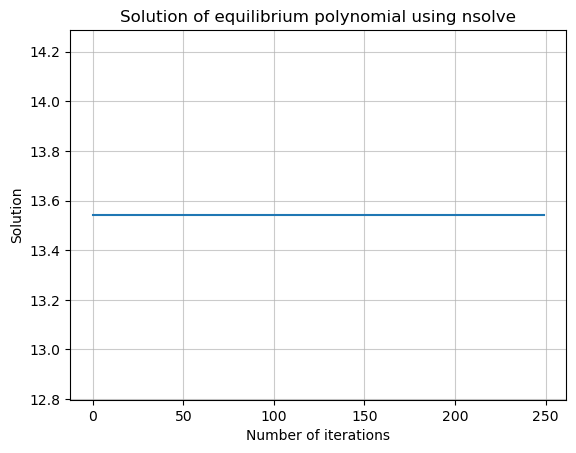

In [92]:
plt.plot(range(0, len(y_solutions)), y_solutions)
plt.xlabel("Number of iterations")
plt.ylabel("Solution")
plt.title("Solution of equilibrium polynomial using nsolve")
plt.grid(alpha=0.66)
plt.show()

In [93]:
NH_3 = 2*solutions[1]
N_2 = sub_replace["N_2"] - solutions[1]
H_2 = sub_replace["H_2"] - 3*solutions[1]
print(f"Concentration of NH3 in the equilibrium solution is: {NH_3:.2f} kmol/m^3")
print(f"Concentration of N2 in the equilibrium solution is: {N_2:.2f} kmol/m^3")
print(f"Concentration of H2 in the equilibrium solution is: {H_2:.2f} kmol/m^3")

# Updating reagents dictionary
reagents_eq = {'H_2': H_2, 'N_2': N_2, 'NH_3': NH_3}
reagents_eq

Concentration of NH3 in the equilibrium solution is: 27.08 kmol/m^3
Concentration of N2 in the equilibrium solution is: 186.46 kmol/m^3
Concentration of H2 in the equilibrium solution is: 159.37 kmol/m^3


{'H_2': 159.373733086487, 'N_2': 186.457911028829, 'NH_3': 27.0841779423420}

In [94]:
# It is neccesary to use solver for estimating NH3 equilibrium concentration.
yi_NH_3 = hm.molar_fraction('NH_3', reagents)
y_NH_3 = hm.molar_fraction('NH_3', reagents_eq)
y_N_2 = hm.molar_fraction('N_2', reagents_eq)
y_H_2 = hm.molar_fraction('H_2', reagents_eq)
print(f"NH3 molar fraction in the equilibrium at initial conditions: {yi_NH_3:.2f}")
print(f"NH3 molar fraction in the equilibrium after reaction: {y_NH_3:.2f}")
print(f"N2 molar fraction in the equilibrium after reaction: {y_N_2:.2f}")
print(f"H2 molar fraction in the equilibrium after reaction: {y_H_2:.2f}")

NH3 molar fraction in the equilibrium at initial conditions: 0.00
NH3 molar fraction in the equilibrium after reaction: 0.07
N2 molar fraction in the equilibrium after reaction: 0.50
H2 molar fraction in the equilibrium after reaction: 0.43


Equation solution using `solve` is retrieving same value, I will iterate over a range of numbers to find a different solution.

In [57]:
eq_t = np.linspace(298.15, 800, 1000)

In [70]:
temp_pols = [
    k_eq_pol.subs(
    {
        "H_2": 200, # Number of kmol/m^3 for H2.
        "N_2": 200, # Number of kmol/m^3 for N2.
        "k_eq": new_k_eq # Equilibrium constant depending on range from 298.15 K to 800 K temperatures.
    }
    ).evalf()

    for new_k_eq in eq_t
]

temp_sols = [
    solve( # Solving the polynomial
    temp_pol, 
    x
    )
    for temp_pol in temp_pols
]

In [95]:
temp_pols

[-4.0*x**4 + 4463968458319.5*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 4193182532731.23*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 3939650477535.63*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 3702221802659.13*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 3479826045784.6*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 3271466981050.17*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 3076217262716.74*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2893213469967.6*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2721651521725.88*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2560782432869.98*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2409908385515.8*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2268379091134.92*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2135588421203.79*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 2010971285848.68*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 1894000741574.59*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 1784185310657.61*(1 - 0.015*x)**3*(200.0 - x),
 -4.0*x**4 + 1681066496150.6*(1 - 0.015*x)**

In [114]:
temp_sols = np.array(temp_sols)
for key in temp_sols:
    for value in key:
        if value.is_real == True:
            print(value.is_real)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [106]:
matrix_rows = []
for idx, key in enumerate(temp_sols):
    NH_3 = 2*key[1]
    N_2 = 200 - key[1]
    H_2 = 200 - 3*key[1]

    matrix_rows.append([H_2, N_2, NH_3])

reagents_eq_temp = np.array(matrix_rows)

# Ammonia molar fraction
y_NH_3_temp = np.array([reagents_eq_temp[x, 2] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))])
# Nitrogen molar fraction
y_N_2_temp = np.array(
    [reagents_eq_temp[x, 1] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))]
    )
# Hydrogen molar fraction
y_H_2_temp = np.array([reagents_eq_temp[x, 0] / np.sum(reagents_eq_temp[x, :]) for x in range(0, len(reagents_eq_temp))])

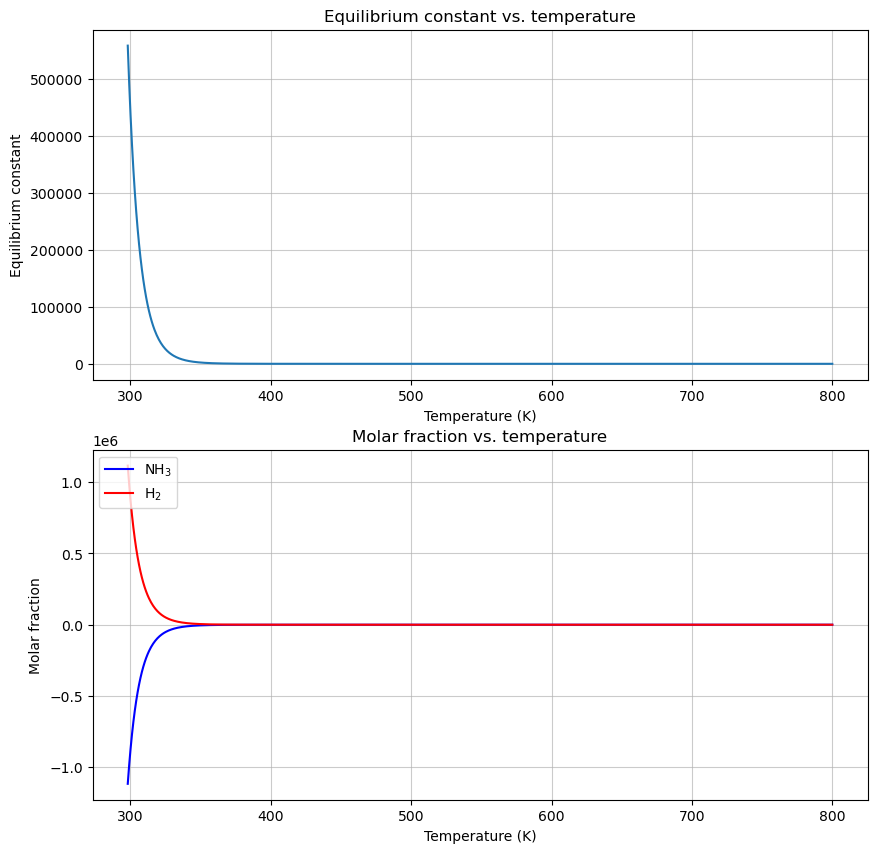

In [107]:
x_temperature = np.linspace(
    start=298.15,
    stop=800,
    num=1000
)

eq_t = hm.equilibrium_constant(x_temperature) # Dependence of equilibria constant on temperature

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(x_temperature, eq_t)
ax[0].set_xlabel("Temperature (K)")
ax[0].set_ylabel("Equilibrium constant")
ax[0].set_title("Equilibrium constant vs. temperature")
ax[0].grid(alpha=0.66)

ax[1].plot(x_temperature, y_NH_3_temp, color = "blue", label = r"NH$_{3}$")
ax[1].plot(x_temperature, y_H_2_temp, color = "red", label = r"H$_{2}$")
ax[1].set_xlabel("Temperature (K)")
ax[1].set_ylabel(r"Molar fraction")
ax[1].set_title("Molar fraction vs. temperature")
ax[1].grid(alpha=0.66)
ax[1].legend(loc="upper left")

plt.show()

In [18]:
# Kinetic constant
k = hm.arrhenius(T=723.15)
k # This constant should not be 0.0, despite ammonia synthesis kinetics are slow, 
#in addition, k should exhibit a higher value when T increase

0.0

In [75]:
# Equilibrium constant
k_eq = hm.equilibrium_constant(T_exp=723.15)

# Fugacities
fug = hm.fugacities(T=723.15, P=33.4)
fug_dict = {
    "H2" : fug[0],
    "N2" : fug[1], # Observe this fugacity.
    "NH3" : fug[2]
}

In [76]:
a_h2, a_n2, a_nh3 = hm.activities(T=723.15, P=33.4, reagents=reagents_eq)

# def ammonia_rate(k, k_eq, a_n2, a_h2, a_nh3, alpha):
#     # Returns ammonia rate
#     r_ammonia = 2 * k * (k_eq**2 * a_n2 * (a_h2**3 / a_nh3**2)**alpha - (a_nh3**2 / a_h2**3)**(1-alpha))

#     return r_ammonia

# Ammonia rate
ammonia_rate = hm.ammonia_rate(1e-2, k_eq, a_h2, a_n2, a_nh3, 0.5)
print(ammonia_rate)

0.750514022211317


In [77]:
print(f"Ln Keq is equal to: {np.log(k_eq):.2f}")
print(f"Activities are: Hydrogen: {a_h2:.2f}, Nitrogen: {a_n2:.2f}, Ammonia: {a_nh3:.2f}")
print(f"Kinetic constant is equal to: {k:.2f}")
# print(f"Molar fractions in the equilibrium are: of NH3 {y_NH_3:.2f}, of N2: {y_N_2:.2f}, of H2: {y_H_2:.2f}")

Ln Keq is equal to: -8.63
Activities are: Hydrogen: 0.43, Nitrogen: 478931.58, Ammonia: 0.12
Kinetic constant is equal to: 0.00


In [82]:
catalyst_eff = hm.catalyst_eff(T=723.15, X=4)
print(catalyst_eff)

-2796254.855268416


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=344a9c6a-e748-4639-9ec7-4bd1ce80f8d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>